# Statistical Rethinking Chapter 5
> Code rewitten in Python to briefly summarise the main takeaways in this chapter
- toc: true 
- badges: true
- comments: true
- categories: [statistical_rethinking]

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
from sklearn.preprocessing import StandardScaler
d = pd.read_csv(
    'https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data/WaffleDivorce.csv', sep=';')
scaler = StandardScaler()
d[['A', 'M', 'D']] = pd.DataFrame(scaler.fit_transform(d[['MedianAgeMarriage', 'Marriage', 'Divorce']]))

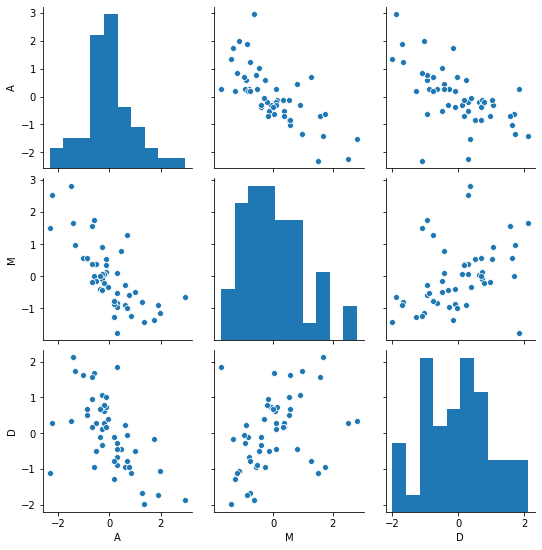

In [4]:
sns.pairplot(d[['A', 'M', 'D']])

## 5.1 Spurious association

### Median age marriage

In [5]:
N = 1000
with pm.Model() as m5_1:
    # Since the outcome and the predictor are both standardized, the intercept should end up very close to zero
    a = pm.Normal('a', 0, 0.2)
    bA = pm.Normal('bA', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bA * d.A
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d.D)
    mean_q = pm.find_MAP()
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, bA, sigma]))

logp = -79.884, ||grad|| = 81.927: 100%|██████████| 11/11 [00:00<00:00, 2207.95it/s]


- Prior

In [6]:
# extract.prior
with m5_1:
    prior = pm.sample_prior_predictive(N)    

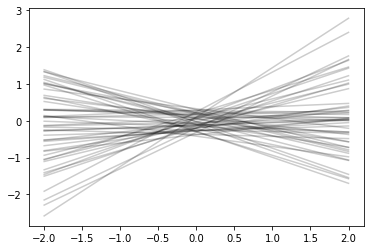

In [7]:
x_seq = np.arange(-2, 3)
a, bA = prior['a'], prior['bA']
for i in range(50):
    y = a[i] + bA[i] * x_seq
    plt.plot(x_seq, y, c='k', alpha=0.2)
plt.show();

- Posterior

In [10]:
x_seq = np.linspace(-3, 3.2, 30)
# link
post = np.random.multivariate_normal(
    [mean_q[k] for k in ['a', 'bA', 'sigma']], cov_q, size=N)
mu = np.apply_along_axis(
    lambda x: post[:, 0] + post[:, 1] * x, 
    axis=1, arr=x_seq[:, np.newaxis])
mu_mean = mu.mean(axis=1)
mu_PI = np.quantile(mu, [0.055, 0.945], axis=1)

Text(0.5, 0, 'Median Age marriage')

Text(0, 0.5, 'Divorce rate')

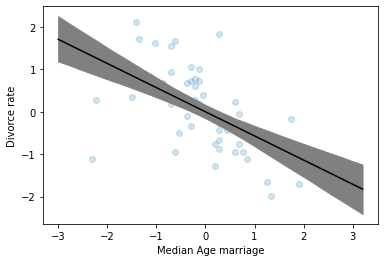

In [11]:
plt.scatter(d.A, d.D, alpha=0.2)
plt.plot(x_seq, mu_mean, c='k')
plt.fill_between(
    x_seq, mu_PI[0], mu_PI[1], color='grey')
plt.xlabel('Median Age marriage')
plt.ylabel('Divorce rate')

### Marriage rate

In [12]:
# exercise 1

### Multiple regression
A -> M  
A -> D

In [32]:
with pm.Model() as m5_3:
    # Since the outcome and the predictor are both standardized, the intercept should end up very close to zero
    a = pm.Normal('a', 0, 0.2)
    bA = pm.Normal('bA', 0, 0.5)
    bM = pm.Normal('bM', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bA * d.A + bM * d.M
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d.D)
with m5_3:
    mean_q = pm.find_MAP()
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, bA, bM, sigma]))  

logp = -61.064, ||grad|| = 0.004354: 100%|██████████| 13/13 [00:00<00:00, 1278.12it/s]  


> Important: Once we know median age at marriage for a State, there is little or no additional predictive power in also knowing the rate of marriage in that State.

In [33]:
print(f"mean: {np.array([mean_q[k] for k in ['a', 'bA', 'bM', 'sigma']]).round(3)}")
print(f'std: {np.sqrt(np.diagonal(cov_q)).round(3)}')

mean: [ 0.    -0.614 -0.065  0.793]
std: [0.098 0.151 0.151 0.079]


#### Counterfactual plots

- M changes across the range of values in M_seq, while the other predictor is held constant at its mean—which is zero, because A is standardized

In [34]:
x_seq = np.linspace(-3, 3.2, 30)
o_seq = np.zeros(30)
# | A=0 | M |
X = np.column_stack([o_seq, x_seq])
# link
post = np.random.multivariate_normal(
    [mean_q[k] for k in ['a', 'bA', 'bM', 'sigma']], cov_q, size=N)
mu = np.apply_along_axis(
    lambda x: post[:, 0] + post[:, 1] * x[0] + post[:, 2] * x[1], 
    axis=1, arr=X)
mu_mean = mu.mean(axis=1)
mu_PI = np.quantile(mu, [0.055, 0.945], axis=1)

In [35]:
# sim
sim_D = np.apply_along_axis(
    lambda x: np.random.normal(post[:, 0] + post[:, 1] * x[0] + post[:, 2] * x[1],
                                   post[:, 3]), axis=1, arr=X)
D_PI = np.quantile(sim_D, [0.055, 0.945], axis=1)

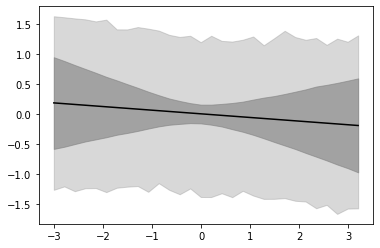

In [36]:
plt.plot(x_seq, mu_mean, c='k')
plt.fill_between(
    x_seq, mu_PI[0], mu_PI[1], color='grey', alpha=0.6)
plt.fill_between(
    x_seq, D_PI[0], D_PI[1], color='grey', alpha=0.3);

> Warning: In the small world of the model, it is possible to change median age of marriage without also changing the marriage rate. But is this also possible in the large world of reality? Probably not...In that case, while these counterfactual plots always help in understanding the model, they may also mislead by displaying predictions for impossible combinations of predictor values.

- M set to its average and A allowed to vary

In [37]:
# exercise 3
# hint: only need to change one line of code!

#### Predictor residual plots
- the linear relationship between divorce and marriage rates, having statistically “controlled” for median age of marriage.

In [38]:
with pm.Model() as m5_4:
    # Since the outcome and the predictor are both standardized, the intercept should end up very close to zero
    a = pm.Normal('a', 0, 0.2)
    bAM = pm.Normal('bAM', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = a + bAM * d.A
    M = pm.Normal('M', mu=mu, sigma=sigma, observed=d.M)
    mean_q = pm.find_MAP()
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, bAM, sigma]))  

logp = -53.827, ||grad|| = 1.2129e-06: 100%|██████████| 12/12 [00:00<00:00, 1313.15it/s]  


In [39]:
post = np.random.multivariate_normal(
    [mean_q[k] for k in ['a', 'bAM', 'sigma']], cov_q, size=N)
mu = np.apply_along_axis(
    lambda x: post[:, 0] + post[:, 1] * x, 
    axis=1, arr=d.A[:, np.newaxis])
mu_mean = mu.mean(axis=1)
mu_resid = d.M - mu_mean

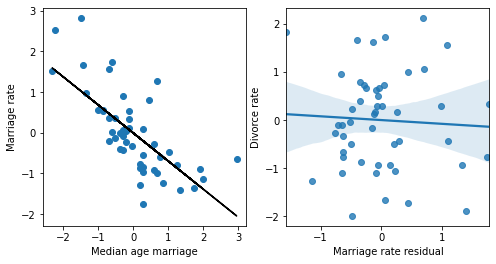

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(d.A, d.M)
axes[0].plot(d.A, mu_mean, c='k')
axes[0].set_xlabel('Median age marriage')
axes[0].set_ylabel('Marriage rate')
# seaborn trick to fit linear regression
sns.regplot(x=mu_resid, y=d.D, ax=axes[1]);
axes[1].set_xlabel('Marriage rate residual')
axes[1].set_ylabel('Divorce rate');

- The linear relationship between divorce and median age marriage, having statistically “controlled” for marriage rate

In [41]:
# exercise 2

#### Posterior prediction plots.

## 5.2 Masked relationship
> Important: A second reason to use more than one predictor variable is to measure the direct influences of multiple factors on an outcome, when none of those influences is apparent from bivariate relationships. This kind of problem tends to arise when there are two predictor variables that are correlated with one another. However, one of these is positively correlated with the outcome and the other is negatively correlated with it.

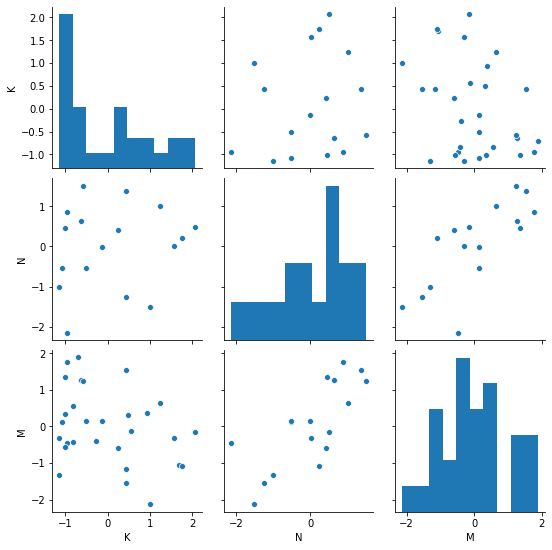

In [42]:
d = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv', sep=';')
d['lmass'] = np.log(d['mass'])
scaler = StandardScaler()
d[['K', 'N', 'M']] = pd.DataFrame(scaler.fit_transform(d[['kcal.per.g', 'neocortex.perc', 'lmass']]))
sns.pairplot(d[['K', 'N', 'M']])

M -> K <- N  
M -> N
> Large animals tend to live a long time. And in such animals, an investment in learning may be a better investment, because learning can be amortized over a longer lifespan. Both large body size and large neocortex then influence milk composition, but in different directions, for different reasons...Body mass (M) influences neocortex percent (N). Both then influence kilocalories in milk (K)...But with the evidence at hand, we cannot easily see which is right.

### Difference when simulating
- Spurious association

In [43]:
n = 100
x_real = np.random.normal(size=n)
x_spur = np.random.normal(x_real, size=n)
y = np.random.normal(x_real, size=n)

- Masked relationship

In [44]:
M = np.random.normal(size=n)
N = np.random.normal(M, size=n)
K = np.random.normal(N - M, size=n)

## 5.3 Categorical variables
### Binary categories
- Indicator variable
$$h_i \sim Normal(\mu_i, \sigma)$$
$$\mu_i \sim \alpha + \beta_i m_i$$
$$\alpha \sim Normal(178, 20)$$
$$\beta_m \sim Normal(0, 10)$$
$$\sigma \sim Uniform(0, 50)$$
> Warning: This can make assigning sensible priors a little harder...Furthermore, this approach necessarily assumes there is more uncertainty about one of the categories
- Index variable
$$h_i \sim Normal(\mu_i, \sigma)$$
$$\mu_i \sim \alpha_{SEX[i]}$$
$$\alpha_j \sim Normal(178, 20), for j=1..2$$
$$\sigma \sim Uniform(0, 50)$$

In [45]:
d = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data/Howell1.csv', sep=';')

In [46]:
with pm.Model() as m5_8:
    a = pm.Normal('a', 178, 20, shape=d['male'].nunique())
    sigma = pm.Uniform('sigma', 0, 50)
    mu = a[d['male'].values]
    height = pm.Normal('height', mu, sigma, observed=d['height'])
    mean_q = pm.find_MAP()
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, sigma]))  

logp = -2,724.8, ||grad|| = 0.026744: 100%|██████████| 14/14 [00:00<00:00, 1679.40it/s]  


In [47]:
mean_q

{'a': array([135.55461973, 143.16814912]),
 'sigma_interval__': array(18.28842903),
 'sigma': array(49.99999943)}

In [48]:
cov_q

array([[  8.46804887,  -0.05219947,  -1.57797704],
       [ -0.05219947,   9.44895653,  -1.44254616],
       [ -1.57797704,  -1.44254616, -43.60780918]])

### Many categories

In [49]:
d = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv', sep=';')
d['K'] = scaler.fit_transform(d[['kcal.per.g']])

In [50]:
with pm.Model() as m5_9:
    a = pm.Normal('a', 0, 0.5, shape=d['clade'].nunique())
    sigma = pm.Exponential('sigma', 1)
    mu = a[d['clade'].astype('category').cat.codes.values]
    K = pm.Normal('K', mu, sigma, observed=d['K'])
    mean_q = pm.find_MAP()
    cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, sigma]))  

logp = -36.531, ||grad|| = 0.0019242: 100%|██████████| 13/13 [00:00<00:00, 1320.85it/s]  


In [51]:
mean_q

{'a': array([-0.48941463,  0.37008325,  0.68048305, -0.58956155]),
 'sigma_log__': array(-0.31019941),
 'sigma': array(0.73330072)}

In [52]:
np.sqrt(np.diagonal(cov_q))

array([0.22105719, 0.2204332 , 0.26134171, 0.27832982, 0.0985117 ])

## Pracitice
### Hard

In [53]:
foxes = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/foxes.csv', sep=';')
foxes[['F', 'G', 'A', 'W']] = pd.DataFrame(scaler.fit_transform(foxes[['avgfood', 'groupsize', 'area', 'weight']]))

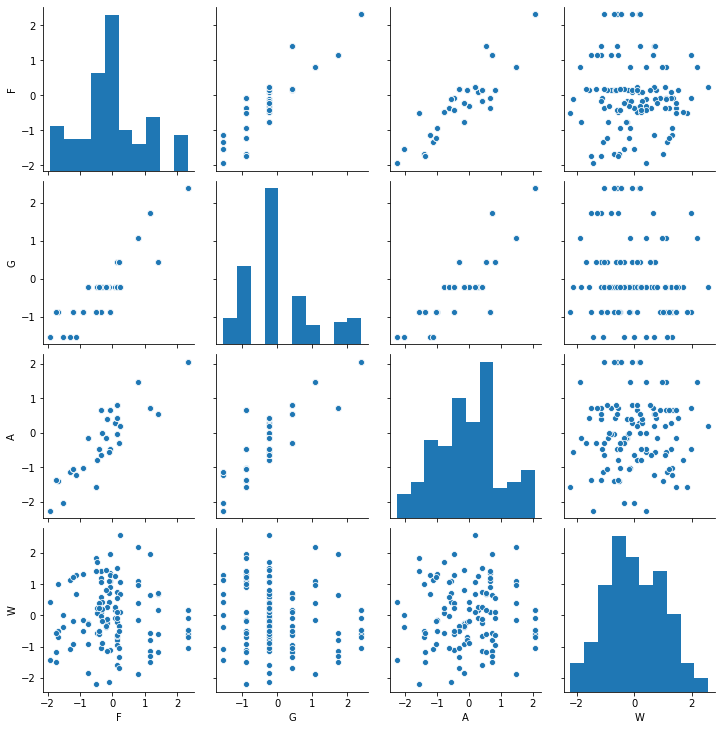

In [59]:
sns.pairplot(foxes[['F', 'G', 'A', 'W']])

In [60]:
def get_post(X, y, N=1000):
    with pm.Model() as model:
        # Since the outcome and the predictor are both standardized, the intercept should end up very close to zero
        a = pm.Normal('a', 0, 0.2)
        b = pm.Normal('b', 0, 0.5, shape=X.shape[1])
        sigma = pm.Exponential('sigma', 1)
        y = pm.Normal('y',
                    mu=a + pm.math.dot(X, b),
                    sigma=sigma,
                    observed=y)
        mean_q = pm.find_MAP()
        means = np.concatenate([mean_q[k].reshape(-1) for k in ['a', 'b', 'sigma']])
        cov_q = np.linalg.inv(pm.find_hessian(mean_q, vars=[a, b, sigma]))  
        stds = np.sqrt(np.diagonal(cov_q))
        post = np.random.multivariate_normal(means, cov_q, size=N)
        print('means: ', means.round(3))
        print('stds: ', stds.round(3))
    return post

In [61]:
def plot_intervals(post, X):
    X = np.concatenate((np.ones(30)[:, np.newaxis], X), axis=1)
    # link
    mu = X.dot(post[:, :-1].T)
    mu_mean = mu.mean(axis=1)
    mu_PI = np.quantile(mu, [0.055, 0.945], axis=1)
    # sim
    sim_D = np.random.normal(mu, post[:, -1])
    D_PI = np.quantile(sim_D, [0.055, 0.945], axis=1)
    plt.plot(x_seq, mu_mean, c='k')
    plt.fill_between(
        x_seq, mu_PI[0], mu_PI[1], color='grey', alpha=0.6)
    plt.fill_between(
        x_seq, D_PI[0], D_PI[1], color='grey', alpha=0.3);

- 5H1 (1)

In [62]:
post = get_post(foxes[['A']], foxes['W'])

logp = -185.03, ||grad|| = 124.83: 100%|██████████| 9/9 [00:00<00:00, 968.59it/s]


means:  [0.    0.019 0.996]
stds:  [0.084 0.091 0.065]


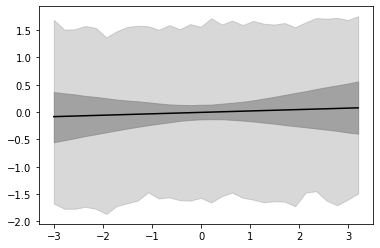

In [63]:
x_seq = np.linspace(-3, 3.2, 30)
plot_intervals(post, x_seq[:, np.newaxis])

- 5H1 (2)

In [64]:
post = get_post(foxes[['G']], foxes['W'])
x_seq = np.linspace(-3, 3.2, 30)

logp = -185.03, ||grad|| = 130.66: 100%|██████████| 9/9 [00:00<00:00, 1038.99it/s]


means:  [ 0.    -0.156  0.983]
stds:  [0.083 0.09  0.064]


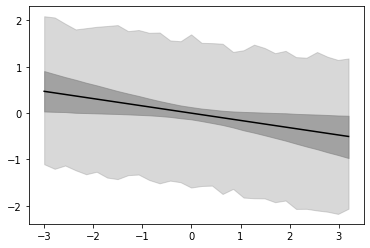

In [65]:
plot_intervals(post, x_seq[:, np.newaxis])

- 5H2

In [66]:
post = get_post(foxes[['A', 'G']], foxes['W'])
x_seq = np.linspace(-3, 3.2, 30)

logp = -185.26, ||grad|| = 130.75: 100%|██████████| 11/11 [00:00<00:00, 2107.59it/s]


means:  [ 0.     0.406 -0.482  0.946]
stds:  [0.08  0.145 0.145 0.062]


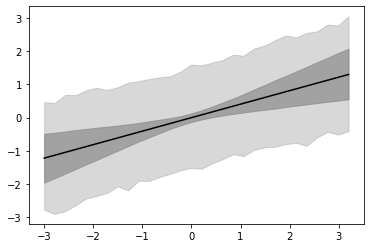

In [67]:
# holding groupsize constant at 0
plot_intervals(post, np.column_stack([np.linspace(-3, 3.2, 30), np.zeros(30)]))

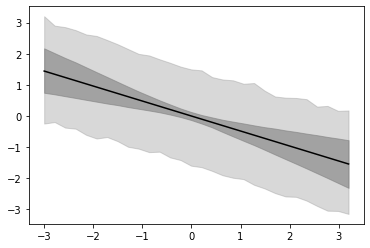

In [68]:
# holding area constant at 0
plot_intervals(post, np.column_stack([np.zeros(30), np.linspace(-3, 3.2, 30)]))

- 5H3

In [69]:
post = get_post(foxes[['F', 'G']], foxes['W'])
x_seq = np.linspace(-3, 3.2, 30)

logp = -160.46, ||grad|| = 5.1972e-06: 100%|██████████| 12/12 [00:00<00:00, 1728.13it/s]  


means:  [ 0.     0.477 -0.574  0.946]
stds:  [0.08  0.179 0.179 0.062]


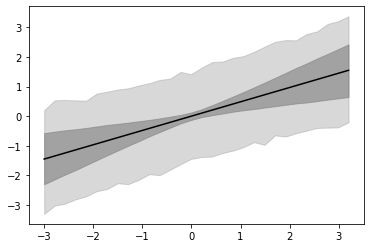

In [70]:
# holding groupsize constant at 0
plot_intervals(post, np.column_stack([np.linspace(-3, 3.2, 30), np.zeros(30)]))

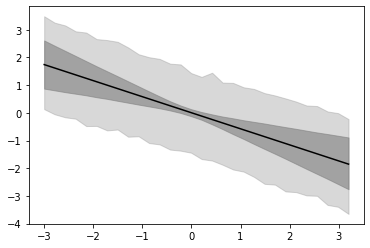

In [71]:
# holding avgfood constant at 0
plot_intervals(post, np.column_stack([np.zeros(30), np.linspace(-3, 3.2, 30)]))

In [72]:
post = get_post(foxes[['A', 'F', 'G']], foxes['W'])

logp = -159.37, ||grad|| = 1.2402: 100%|██████████| 16/16 [00:00<00:00, 2502.29it/s]  


means:  [ 0.     0.278  0.297 -0.64   0.935]
stds:  [0.08  0.17  0.21  0.182 0.061]
